In [1]:
import copy
import re
import os
import xarray as xr
from cheat.game import CheatGame
from cheat.bots import RandomBot, SmartBot, LLM_Player
from cheat.player import get_player
from cheat.card import RANK_ORDER, str_to_Card
import numpy as np
import asyncio
import logging
import tqdm
import json
import pickle
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import pandas as pd

from evaluate.styles import colors
from evaluate.utils import setup_game
plt.style.use(['evaluate.styles.default_style', 'evaluate.styles.font_helvetica', 'evaluate.styles.font_size_9'])

# One RandomBot, Three SmartBots
In this first experiment, we pair three SmartBots against a single RandomBot, and vary the RandomBot's call and lie probability. The best strategy for the RandomBot is to have a low probability of lying and a low probability of calling.

In [28]:
one_random = xr.DataArray(np.zeros((4, 11, 11)), dims=['Player', 'p_lie', 'p_call'], coords={'Player': np.arange(4)}, name='Win rate [%]')
one_random_strategy = xr.DataArray(np.zeros((3, 11, 11)), dims=['Player', 'p_lie', 'p_call'], coords={'Player': np.arange(3)})
one_random_strategy = xr.Dataset(dict(lie=one_random_strategy.copy(), call=one_random_strategy.copy()))
one_random_round_length = xr.DataArray(np.zeros((10, 11, 11)), dims=['Round', 'p_lie', 'p_call'], coords={'Round': np.arange(10)})
one_random = one_random.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )
one_random_strategy = one_random_strategy.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )
one_random_round_length = one_random_round_length.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )

# Extract the information
for dir in os.listdir("game_data/experiments/game_one_random"):
    if dir.startswith('.'):
        continue
    with open(f"game_data/experiments/game_one_random/{dir}/game_history.jsonl", "r") as f:
        game_hist = [json.loads(line) for line in f if line.strip()]
    m = re.search(r"p_lie_([0-9]*\.?[0-9]+)_p_call_([0-9]*\.?[0-9]+)", dir)
    if m:
        p_lie = float(m.group(1))
        p_call = float(m.group(2))

    winners = np.unique([a['player_id'] for a in game_hist if a['type']=='win'], return_counts=True)
    for idx in range(len(winners[0])):
        one_random.loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': winners[0][idx]}] = winners[1][idx] / 10 * 100
    for i in range(3):
        with open(f"game_data/experiments/game_one_random/{dir}/players/Player_{i}.pickle", "rb") as file:
            player_dict = pickle.load(file)
        one_random_strategy['lie'].loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': i}] = player_dict['other_player_repr_hist'][i]['p_lie_est'][-1]
        one_random_strategy['call'].loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': i}] = player_dict['other_player_repr_hist'][i]['p_call_est'][-1]

    # Count the round lengths
    r = 0 # Round number
    l = 0 # Number of plays
    for a in game_hist[1:]:
        if a['type'] == 'new_round':
            one_random_round_length.loc[{"Round": r, 'p_call': p_call, 'p_lie': p_lie}] = l
            l = 0
            r += 1
        elif a['type'] in ['call', 'play']:
            l +=1
one_random = one_random.assign_coords({"Player": ['SmartBot 1', 'SmartBot 2', 'SmartBot 3', 'RandomBot']})
one_random_strategy = one_random_strategy.assign_coords({"Player": ['SmartBot 1', 'SmartBot 2', 'SmartBot 3']})

This plot shows the win rate for each player, calculated over 10 rounds:

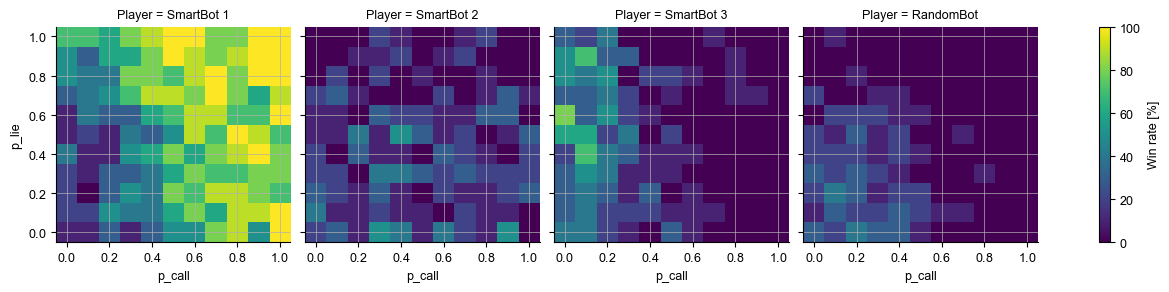

In [3]:
one_random.plot.imshow(col='Player')

We can also look at the strategies the three SmartBots employ. For SmartBot1 (behind RandomBot), the call probability is linearly proportional to RandomBot's lie probability. For SmartBot3 (in front of RandomBot), the lie probability is inversely proportional to RandomBot's call probability.

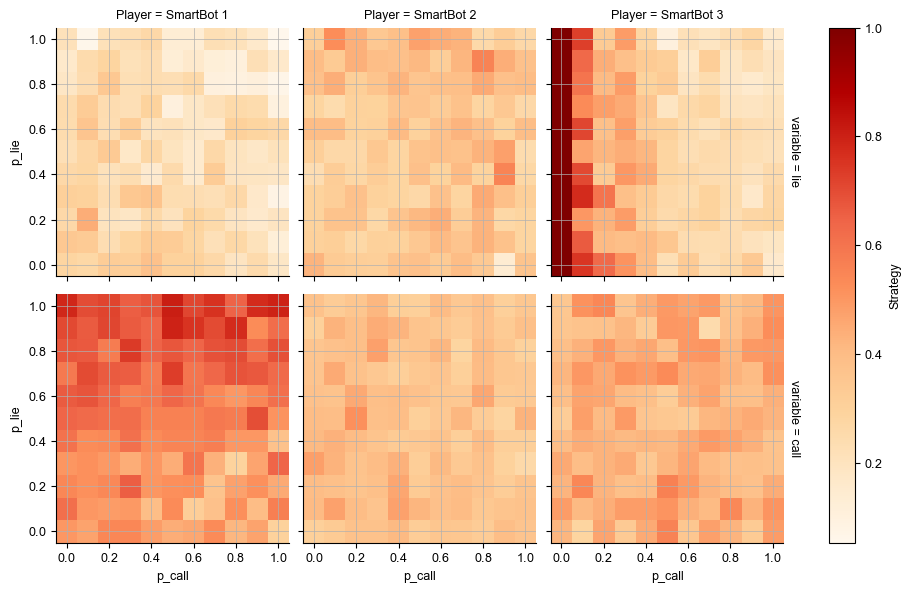

In [4]:
one_random_strategy.to_dataarray().rename('Strategy').plot.imshow(col='Player', row='variable', cmap='OrRd')

We can look at the lengths of each round:

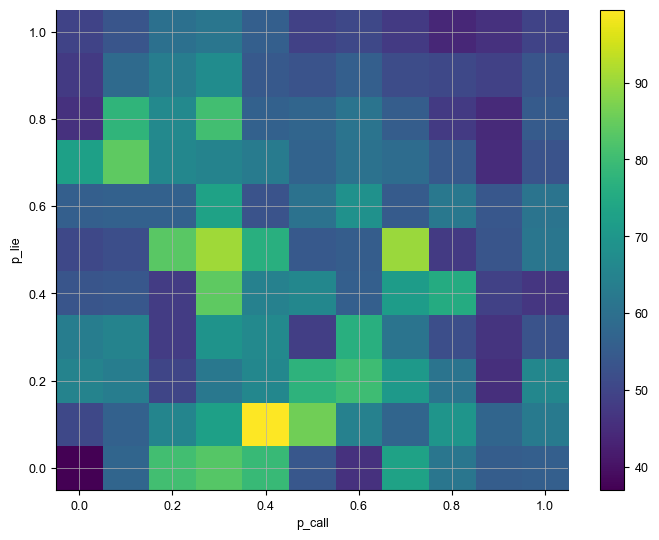

In [5]:
one_random_round_length.median('Round').plot.imshow()

## One SmartBot, Others RandomBots

In [6]:
one_smart = xr.DataArray(np.zeros((4, 11, 11)), dims=['Player', 'p_lie', 'p_call'], coords={'Player': np.arange(4)}, name='Win rate [%]')
one_smart_strategy = xr.DataArray(np.zeros((1, 11, 11)), dims=['Player', 'p_lie', 'p_call'], coords={'Player': np.arange(1)})
one_smart_strategy = xr.Dataset(dict(lie=one_smart_strategy.copy(), call=one_smart_strategy.copy()))
one_smart_round_length = xr.DataArray(np.zeros((10, 11, 11)), dims=['Round', 'p_lie', 'p_call'], coords={'Round': np.arange(10)})
one_smart = one_smart.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )
one_smart_strategy = one_smart_strategy.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )
one_smart_round_length = one_smart_round_length.assign_coords(
        {'p_lie': np.round(np.linspace(0, 1, 11), 2), 'p_call': np.round(np.linspace(0, 1, 11), 2)}
    )

for dir in os.listdir("game_data/experiments/game_one_smart"):
    if dir.startswith('.'):
        continue
    with open(f"game_data/experiments/game_one_smart/{dir}/game_history.jsonl", "r") as f:
        game_hist = [json.loads(line) for line in f if line.strip()]
    m = re.search(r"p_lie_([0-9]*\.?[0-9]+)_p_call_([0-9]*\.?[0-9]+)", dir)
    if m:
        p_lie = float(m.group(1))
        p_call = float(m.group(2))
    winners = np.unique([a['player_id'] for a in game_hist if a['type']=='win'], return_counts=True)
    for idx in range(len(winners[0])):
        one_smart.loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': winners[0][idx]}] = winners[1][idx] / 10 * 100
    for i in range(1):
        with open(f"game_data/experiments/game_one_smart/{dir}/players/Player_{i}.pickle", "rb") as file:
            player_dict = pickle.load(file)
        one_smart_strategy['lie'].loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': i}] = player_dict['other_player_repr_hist'][i]['p_lie_est'][-1]
        one_smart_strategy['call'].loc[{'p_call': p_call, 'p_lie': p_lie, 'Player': i}] = player_dict['other_player_repr_hist'][i]['p_call_est'][-1]

    # Count the round lengths
    r = 0 # Round number
    l = 0 # Number of plays
    for a in game_hist[1:]:
        if a['type'] == 'new_round':
            one_smart_round_length.loc[{"Round": r, 'p_call': p_call, 'p_lie': p_lie}] = l
            l = 0
            r += 1
        elif a['type'] in ['call', 'play']:
            l +=1

one_smart = one_smart.assign_coords({"Player": ['SmartBot', 'RandomBot 1', 'RandomBot 2', 'RandomBot 3']})
one_smart_strategy = one_smart_strategy.assign_coords({"Player": ['SmartBot']})

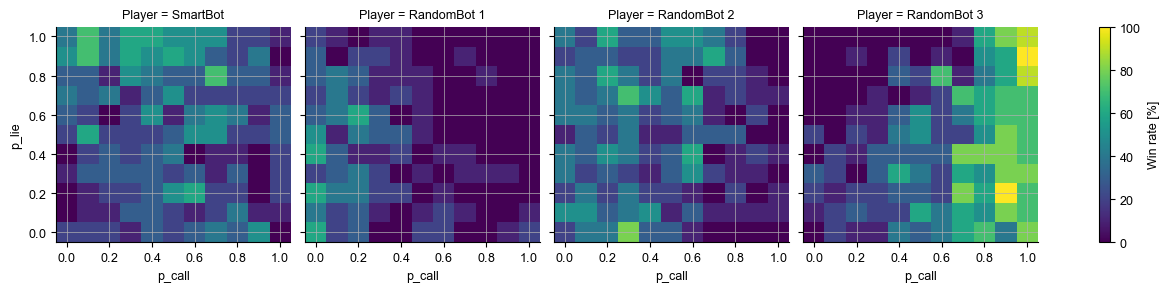

In [7]:
one_smart.plot.imshow(col='Player')

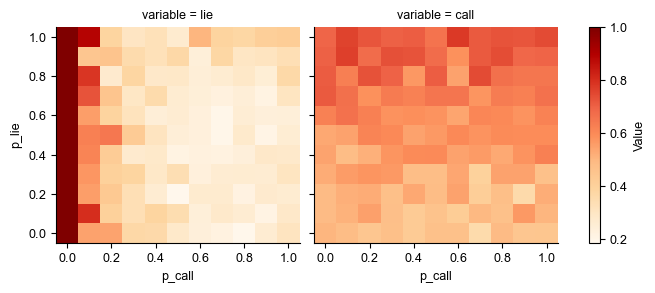

In [8]:
one_smart_strategy.to_dataarray().rename('Value').plot(col='variable', cmap='OrRd')

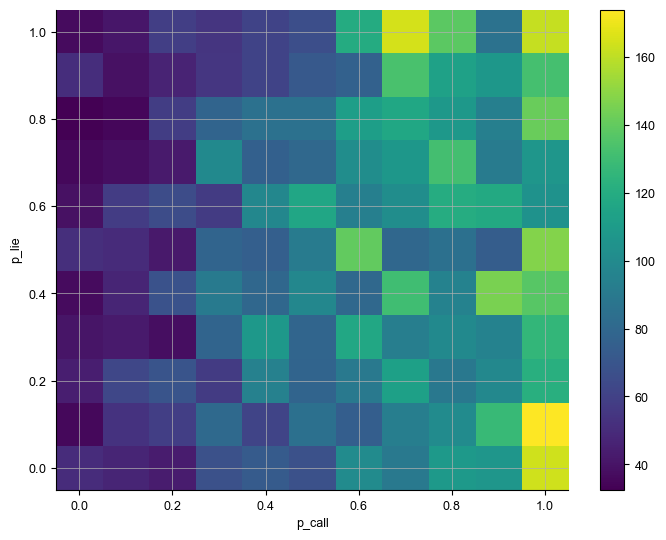

In [9]:
one_smart_round_length.median('Round').plot.imshow()

In [10]:
game_one_smart = setup_game({"players": [
    {"type": "SmartBot", "id": 0, "name": "SmartBot", "verbosity": 0.0},
    {"type": "RandomBot", "id": 1, "name": "RandomBot_1", "p_lie": np.random.rand(), "p_call": np.random.rand(),"verbosity": 0.0},
    {"type": "RandomBot", "id": 2, "name": "RandomBot_2", "p_lie": np.random.rand(), "p_call": np.random.rand(),"verbosity": 0.0},
    {"type": "RandomBot", "id": 3, "name": "RandomBot_3", "p_lie": np.random.rand(), "p_call": np.random.rand(),"verbosity": 0.0},
]}, out_dir="~/Cheat_game_data")

In [11]:
# Play
n_rounds = 10
for i in tqdm.trange(n_rounds):
    await game_one_smart.play_round(sleep_pause=0)
    if i < n_rounds-1:
        game_one_smart.new_round()
    else:
        game_one_smart.game_over = True

100%|██████████| 10/10 [02:13<00:00, 13.34s/it]


Text(0.5, 1.15, "SmartBot's model of RandomBots")

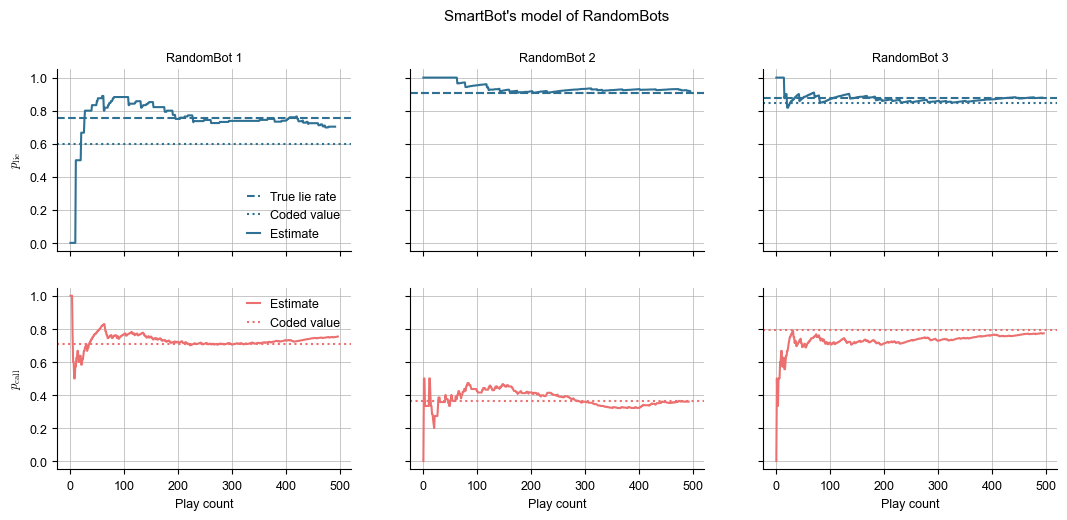

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=game_one_smart.num_players-1, figsize=(10, 4), sharey=True, sharex=True)
axs= axs.reshape(2, -1)
for idx, p in enumerate(game_one_smart.players):
    if isinstance(p, SmartBot):
        continue
    axs[0, idx-1].axhline(1-len([action for action in game_one_smart.history if action.type == 'play' and action.player_id == p.id and all([action.data['declared_rank'] == c.rank for c in action.data['cards_played']])]) / len([action for action in game_one_smart.history if action.type == 'play' and action.player_id == p.id]), ls='dashed', label='True lie rate'
    )
    axs[0, idx-1].axhline(p.p_lie, ls='dotted', label='Coded value')

    axs[0, idx-1].plot(game_one_smart.players[0].other_player_repr_hist[idx]['p_lie_est'], label='Estimate')
    axs[1, idx-1].plot(game_one_smart.players[0].other_player_repr_hist[idx]['p_call_est'], c=colors['c_red'], label='Estimate')
    axs[1, idx-1].axhline(p.p_call, ls='dotted', c=colors['c_red'], label='Coded value')
    axs[0, idx-1].set(title=f"RandomBot {idx}")
    axs[1, idx-1].set(xlabel='Play count')
axs[0, 0].set(ylabel=r'$p_{\mathrm{lie}}$')
axs[1, 0].set(ylabel=r'$p_\mathrm{call}$')
axs[0, 0].legend()
axs[1, 0].legend()
fig.suptitle("SmartBot's model of RandomBots", y=1.15)

In [87]:
from cheat.player import get_player
from cheat.action import GameAction

def dict_to_action(*, type: str, player_id: int, timestamp: str, data: dict, **__):
    return GameAction(
        type=type,
        player_id=player_id,
        timestamp=pd.to_datetime(timestamp),
        data=data
    )

def load_game(dir) -> CheatGame:

    # Load the players
    players = []
    for file in os.listdir(os.path.join(dir, 'Players')):
        with open(os.path.join(dir, 'Players', file), 'rb') as f:
            player_dict = pickle.load(f)

            if 'other_player_repr_hist' in player_dict.keys():
                player_dict['type'] = 'SmartBot'
                players.append(get_player(player_dict))
                players[-1].other_player_repr_hist = player_dict['other_player_repr_hist']
                players[-1].other_player_repr = dict((k, dict((_k, _v[-1]) for _k, _v in v.items())) for k, v in players[-1].other_player_repr_hist.items())

            elif 'p_call' in player_dict.keys():
                player_dict['type'] = 'RandomBot'
                players.append(get_player(player_dict))
            else:
                players.append(get_player(player_dict))

    # Set up the game
    game = CheatGame(
        players=players,
        experimental_mode=False,
        game_mode='single',
        message_queue = asyncio.Queue(), # Set up a new queue: each game maintains its own queue
        out_dir=None,
        note=None
    )

    # Convert the game history
    with open(f"{dir}/game_history.jsonl", "r") as f:
        game_hist = [json.loads(line) for line in f if line.strip()]
    game.history = [dict_to_action(**item) for item in game_hist]

    # Set the round counter
    game.round = len([a for a in game.history if a.type=='new_round'])

    return game

def get_player_stats(game) -> list:
    """ Get the play statistics for each player """
    player_stats = [dict((k, {'Correct plays': 0, 'Bluffs missed': 0, 'Incorrectly called': 0, 'Bluff sizes': []}) for k in range(game.num_players)) for _ in range(game.round)]

    round_idx = 0
    for idx, action in enumerate(game.history):
        if idx == 0:
            continue
        if action.type == 'new_round':
            round_idx += 1
            continue
        if action.type == 'play':
            if not all([str_to_Card(c) == action.data['declared_rank'] for c in action.data['cards_played'] ]):
                player_stats[round_idx][action.player_id]['Bluff sizes'].append(len(action.data['cards_played']))
            for _action in game.history[idx::-1]:
                if _action.type == 'play':
                    if all([str_to_Card(c) == _action.data['declared_rank'] for c in _action.data['cards_played'] ]):
                        player_stats[round_idx][action.player_id]['Correct plays'] += 1
                    else:
                        player_stats[round_idx][action.player_id]['Bluffs missed'] += 1
                    break
        elif action.type == 'call':
            if action.data['was_lying']:
                player_stats[round_idx][action.player_id]['Correct plays'] +=1
                player_stats[round_idx][action.data['accused_id']]['Bluff sizes'].append(len(action.data['revealed_cards']))
            else:
                player_stats[round_idx][action.player_id]['Incorrectly called'] += 1

    return player_stats

In [88]:
game = load_game(f"game_data/experiments/game_one_random/{dir}")

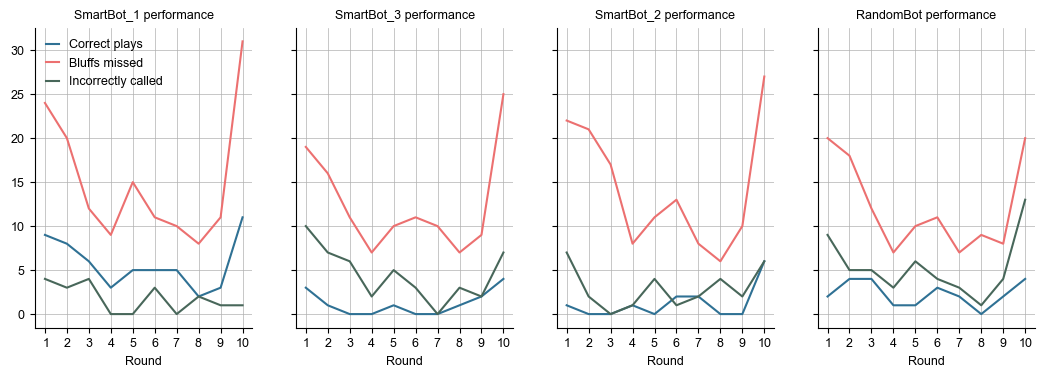

In [90]:
# Plays missed and incorrectly called
player_stats = get_player_stats(game)
fig, axs = plt.subplots(ncols=game.num_players, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(game_one_smart.num_players):
    for key in player_stats[0][0].keys():
        if key == 'Bluff sizes':
            continue
        axs[pid].plot(np.arange(len(player_stats))+1, [item[pid][key] for item in player_stats], label=key)
    axs[pid].set(title=f'{game.players[pid].name} performance', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(1))
axs[0].legend()

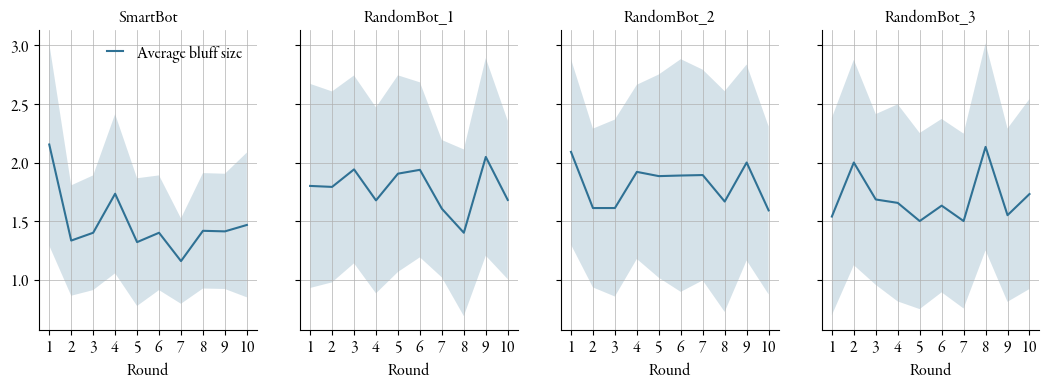

In [253]:
# Plays missed and incorrectly called
fig, axs = plt.subplots(ncols=game_one_smart.num_players, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(game_one_smart.num_players):
    x = np.arange(len(player_stats))+1
    y = np.array([np.mean(item[pid]['Bluff sizes']) for item in player_stats])
    yerr = np.array([np.std(item[pid]['Bluff sizes']) for item in player_stats])
    axs[pid].fill_between(x, y-yerr, y+yerr, alpha=0.2)
    axs[pid].plot(x, y, label='Average bluff size')
    axs[pid].set(title=f'{game_one_smart.players[pid].name}', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(1))
axs[0].legend()

## All SmartBots

In [26]:
game_all_smart = setup_game({"players": [
    {"type": "SmartBot", "id": 0, "name": "SmartBot_1", "verbosity": 0.0},
    {"type": "SmartBot", "id": 1, "name": "SmartBot_2", "verbosity": 0.0},
    {"type": "SmartBot", "id": 2, "name": "SmartBot_3", "verbosity": 0.0},
    {"type": "SmartBot", "id": 3, "name": "SmartBot_4", "verbosity": 0.0},
]}, out_dir="~/Cheat_game_data")

In [42]:
# Play
n_rounds = 20
for i in tqdm.trange(n_rounds):
    await game_all_smart.play_round(sleep_pause=0)
    if i < n_rounds-1:
        game_all_smart.new_round()
    else:
        game_all_smart.game_over = True

100%|██████████| 20/20 [02:23<00:00,  7.16s/it]


Text(0.5, 1.15, "SmartBots' models of each other")

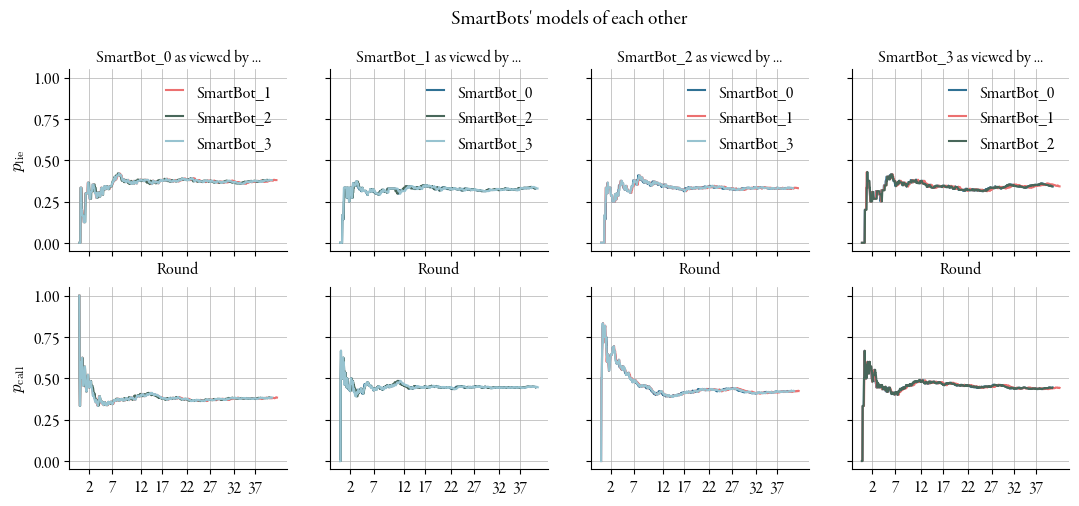

In [291]:
fig, axs = plt.subplots(nrows=2, ncols=game_all_smart.num_players, figsize=(10, 4), sharey=True, sharex='col')
for idx, p in enumerate(game_all_smart.players):
    for k, v in p.other_player_repr_hist.items():
        if k == idx:
            continue
        # Length of each round
        r = 0
        len_of_rounds = dict()
        for a in game_all_smart.history:
            if a.type == 'new_round':
                r+=1
                if r == 1:
                    len_of_rounds[r] = 0
                else:
                    len_of_rounds[r]=len_of_rounds[r-1]
                continue
            elif a.type in ['call', 'play'] and a.player_id == idx:
                len_of_rounds[r] +=1
        axs[0, k].plot(v['p_lie_est'], c=list(colors.values())[idx], label=f'SmartBot_{idx}')
        axs[1, k].plot(v['p_call_est'], c=list(colors.values())[idx], label=f'SmartBot_{idx}')
        axs[0, k].set(title=f"SmartBot_{k} as viewed by ...", xlabel='Round')
        axs[0, k].legend()
        axs[1, k].set_xticks(np.array(list(len_of_rounds.values())[::5]), np.array(list(len_of_rounds.keys())[::5])+1)
        #axs[1, k].xaxis.set_major_locator(MultipleLocator(1))
axs[0, 0].set(ylabel=r'$p_{\mathrm{lie}}$')
axs[1, 0].set(ylabel=r'$p_\mathrm{call}$')
fig.suptitle("SmartBots' models of each other", y=1.15)

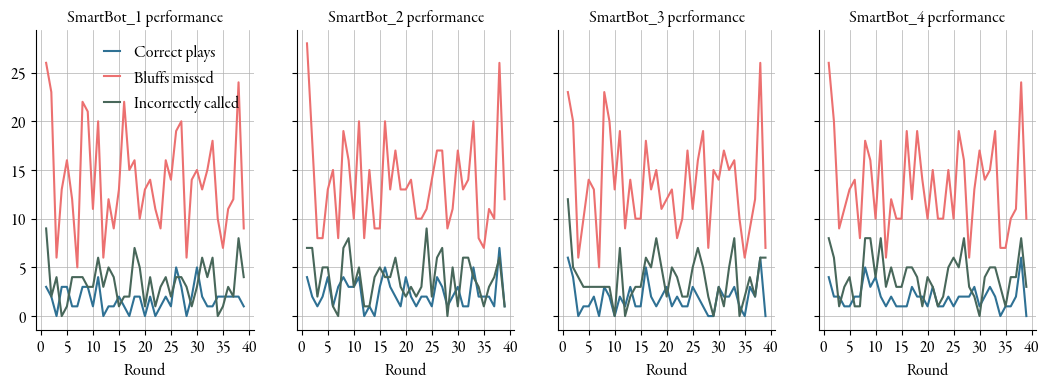

In [172]:
# Plays missed and incorrectly called
player_stats = get_player_stats(game_all_smart)
fig, axs = plt.subplots(ncols=game_all_smart.num_players, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(game_all_smart.num_players):
    for key in player_stats[0][0].keys():
        if key == 'Bluff sizes':
            continue
        axs[pid].plot(np.arange(len(player_stats))+1, [item[pid][key] for item in player_stats], label=key)
    axs[pid].set(title=f'{game_all_smart.players[pid].name} performance', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(5))
axs[0].legend()

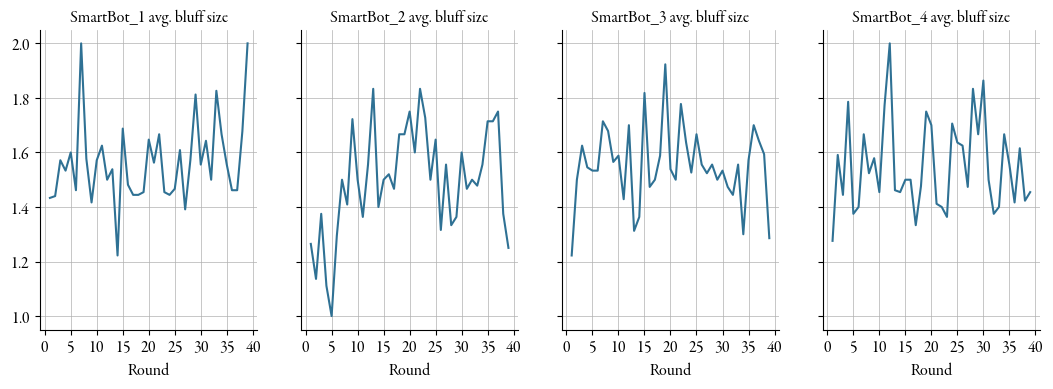

In [174]:
# Plays missed and incorrectly called
fig, axs = plt.subplots(ncols=game_all_smart.num_players, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(game_all_smart.num_players):
    axs[pid].plot(np.arange(len(player_stats))+1, [np.mean(item[pid]['Bluff sizes']) for item in player_stats], label='Average bluff size')
    axs[pid].set(title=f'{game_all_smart.players[pid].name} avg. bluff size', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(5))

## One human, three SmartBots

In [304]:
# Reconstruct a DataFrame for each round
with open(f"/Users/thomasgaskin/Cheat_game_data/game_20251218_124756/game_history.jsonl", "r") as f:
    game_history_human_vs_SB = [json.loads(line) for line in f if line.strip()]
players_info = []
for i in range(1, 4):
    with open(f"/Users/thomasgaskin/Cheat_game_data/game_20251218_124756/players/Player_{i}.pickle", "rb") as f:
        players_info.append(pickle.load(f))

Text(0.5, 1.15, "SmartBots' models of other players")

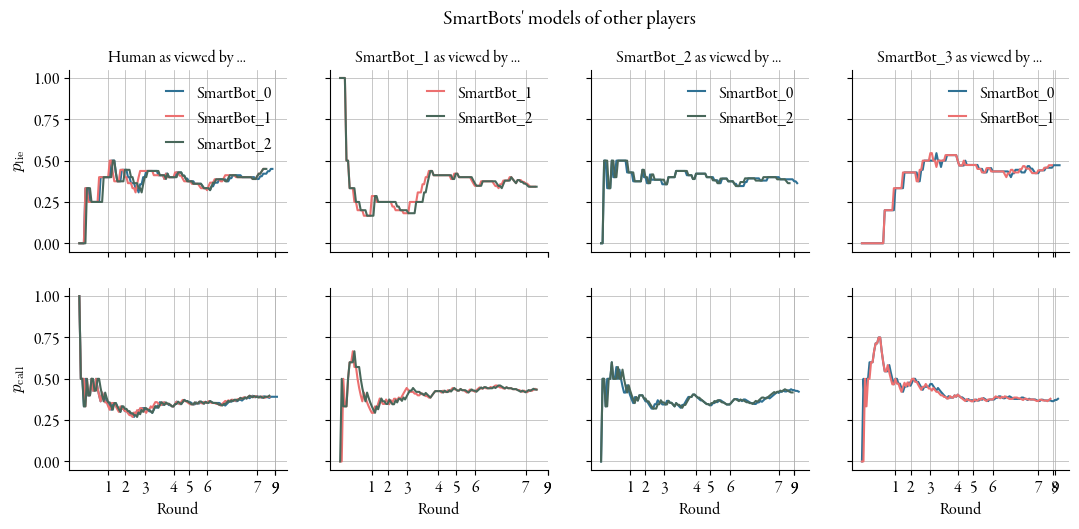

In [305]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 4), sharey=True, sharex='col')
for idx, p in enumerate(players_info):
    for k, v in p['other_player_repr_hist'].items():
        if k == p['id']:
            continue
        # Length of each round
        len_of_rounds = dict((r, len([a for a in game_history_human_vs_SB if a['round']==r and a['player_id'] == k and a['type'] in ['call', 'play']])) for r in range(1, game_history_human_vs_SB[-1]['round']+1))
        for r in range(2, game_history_human_vs_SB[-1]['round']+1):
            len_of_rounds[r] += len_of_rounds[r-1]
        axs[0, k].plot(v['p_lie_est'], c=list(colors.values())[idx], label=f'SmartBot_{idx}')
        axs[1, k].plot(v['p_call_est'], c=list(colors.values())[idx], label=f'SmartBot_{idx}')
        axs[0, k].set(title=f"SmartBot_{k} as viewed by ... " if k!= 0 else 'Human as viewed by ... ')
        axs[1, k].set(xlabel='Round')
        axs[0, k].legend()
        axs[1, k].set_xticks(list(len_of_rounds.values()), list(len_of_rounds.keys()))
axs[0, 0].set(ylabel=r'$p_{\mathrm{lie}}$')
axs[1, 0].set(ylabel=r'$p_\mathrm{call}$')

fig.suptitle("SmartBots' models of other players", y=1.15)

In [306]:
def get_player_stats_from_history(history, num_players):
    player_stats = [dict((k, {'Correct plays': 0, 'Bluffs missed': 0, 'Incorrectly called': 0, 'Bluff sizes': []}) for k in range(num_players)) for _ in range(history[-1]['round'])]
    round_idx = 0
    for idx, action in enumerate(history):
        if idx == 0:
            continue
        if action['type'] == 'new_round':
            round_idx += 1
            continue
        if action['type'] == 'play':
            if not all([str_to_Card(c) == action['data']['declared_rank'] for c in action['data']['cards_played'] ]):
                player_stats[round_idx][action['player_id']]['Bluff sizes'].append(len(action['data']['cards_played']))
            for _action in history[idx::-1]:
                if _action['type'] == 'play':
                    if all([str_to_Card(c) == _action['data']['declared_rank'] for c in _action['data']['cards_played'] ]):
                        player_stats[round_idx][action['player_id']]['Correct plays'] += 1
                    else:
                        player_stats[round_idx][action['player_id']]['Bluffs missed'] += 1
                    break
        elif action['type'] == 'call':
            if action['data']['was_lying']:
                player_stats[round_idx][action['player_id']]['Correct plays'] +=1
                player_stats[round_idx][action['data']['accused_id']]['Bluff sizes'].append(len(action['data']['revealed_cards']))
            else:
                player_stats[round_idx][action['player_id']]['Incorrectly called'] += 1
    return player_stats

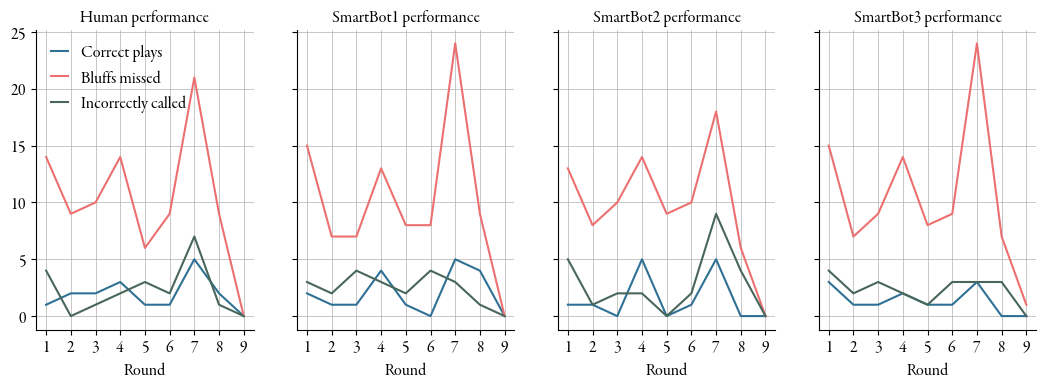

In [307]:
# Plays missed and incorrectly called
player_stats_human=get_player_stats_from_history(game_history_human_vs_SB, num_players=4)
fig, axs = plt.subplots(ncols=4, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(4):
    for key in player_stats_human[0][0].keys():
        if key == "Bluff sizes":
            continue
        axs[pid].plot(np.arange(len(player_stats_human))+1, [item[pid][key] for item in player_stats_human], label=key)
    axs[pid].set(title=f'SmartBot{pid} performance' if pid !=0 else 'Human performance', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(1))
axs[0].legend()

/Users/thomasgaskin/Projects/Cheat_Game/.Cheat_venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasgaskin/Projects/Cheat_Game/.Cheat_venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/thomasgaskin/Projects/Cheat_Game/.Cheat_venv/lib/python3.11/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thomasgaskin/Projects/Cheat_Game/.Cheat_venv/lib/python3.11/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/thomasgaskin/Projects/Cheat_Game/.Cheat_venv/lib/python3.11/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in s

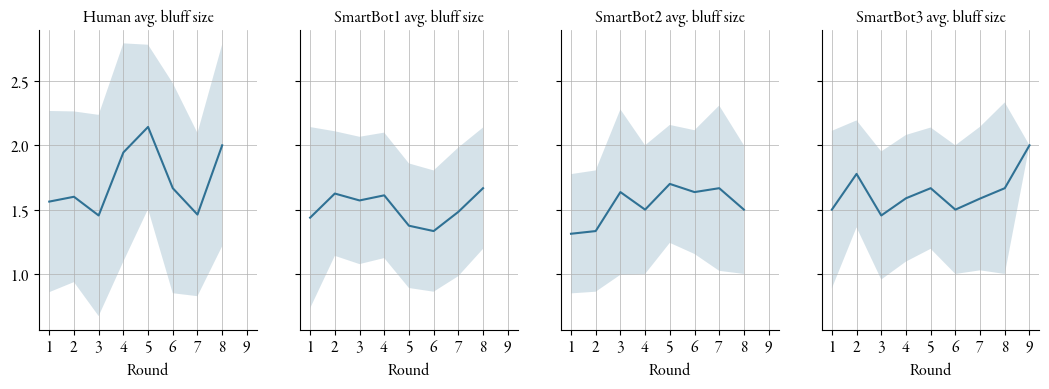

In [308]:
# Plays missed and incorrectly called
fig, axs = plt.subplots(ncols=4, figsize=(10, 3), sharey=True, sharex=True)
for pid in range(4):
    x = np.arange(len(player_stats_human))+1
    y = np.array([np.mean(item[pid]['Bluff sizes']) for item in player_stats_human])
    yerr = np.array([np.std(item[pid]['Bluff sizes']) for item in player_stats_human])
    axs[pid].fill_between(x, y-yerr, y+yerr, alpha=0.2)
    axs[pid].plot(x, y, label='Average bluff size')
    axs[pid].set(title=f'SmartBot{pid} avg. bluff size' if pid !=0 else 'Human avg. bluff size', xlabel='Round')
    axs[pid].xaxis.set_major_locator(MultipleLocator(1))

In [309]:
def history_to_df(game_history):

    def deep_copy_row(df_row):
        """Create a deep copy of a DataFrame row with list columns"""
        row_dict = df_row.to_dict()
        for key, value in row_dict.items():
            if isinstance(value, list):
                row_dict[key] = value.copy()
        return pd.Series(row_dict)

    game_data = pd.DataFrame(columns=['game_id', 'round', 'state', 'Pile', 'Discards'] + [f'Player {p.id}' for p in game.players])
    for record in game_history:

        # New round: write initial state
        if record['type'] == 'new_round':
            # Extract data
            game_id = record['game_id']
            round_num = record['round']
            state = record['type']  # 'new_round'

            # Extract player hands from the nested data
            player_hands = record['data']['player_hands']

            # Create row data - fill player columns with their hand strings
            row_data = {
                'game_id': game_id,
                'round': round_num,
                'state': state,
                'Player': '',
                'Current rank': None,
                'Pile': [],  # Not in this record
                'Discards': []  # Not in this record
            }

            # Add player hand columns
            for player_key, hand in player_hands.items():
                # player_key is '0', '1', etc.
                # Convert hand list to string representation
                row_data[f'Player {player_key}'] = copy.deepcopy(hand) if hand else []

            # Fill missing player columns with empty string
            for i in range(4):  # Assuming 4 players
                col_name = f'Player {i}'
                if col_name not in row_data:
                    row_data[col_name] = ''

            # Create DataFrame row and append
            row_df = pd.DataFrame([row_data])
            game_data = pd.concat([game_data, row_df], ignore_index=True)

        # Play: move played cards from Players hands to pile
        elif record['type'] == 'play':
            row_df = deep_copy_row(game_data.iloc[-1])
            row_df['state'] = 'play'
            row_df['Player'] = record['player_id']
            row_df['Current rank'] = record['data']['declared_rank']
            cards_played = record['data']['cards_played']
            for c in cards_played:
                row_df[f"Player {record['player_id']}"].remove(c)
                row_df["Pile"].append(c)
            game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

        # Call: move pile from Players who successfully called
        elif record['type'] == 'call':
            row_df = deep_copy_row(game_data.iloc[-1])
            row_df['state'] = 'call'
            row_df['Current rank'] = None
            row_df['Player'] = record['player_id']
            accused_id = record['data']['accused_id']
            if record['data']['was_lying']:
                add_to_player = f"Player {record['data']['accused_id']}"
            else:
                add_to_player = f"Player {record['player_id']}"
            row_df[add_to_player].extend(row_df['Pile'])
            row_df[add_to_player] = sorted(row_df[add_to_player], key=lambda c: RANK_ORDER[c[:-1]])
            row_df['Pile'] = []

            game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

        # Discards
        elif record['type'] == 'discard':
            row_df = deep_copy_row(game_data.iloc[-1])
            row_df['Player'] = record['player_id']
            row_df['state'] = 'discard'

            row_df['Discards'].extend([c for c in row_df[f"Player {record['player_id']}"] if c[:-1] in record['data']])
            row_df[f"Player {record['player_id']}"] = [c for c in row_df[f"Player {record['player_id']}"] if c[:-1] not in record['data']]
            game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)

        # Win
        elif record['type'] == 'win':
            row_df = deep_copy_row(game_data.iloc[-1])
            row_df['Player'] = record['player_id']
            row_df['state'] = 'win'
            game_data = pd.concat([game_data, pd.DataFrame(row_df).T], ignore_index=True, axis=0)
    return game_data

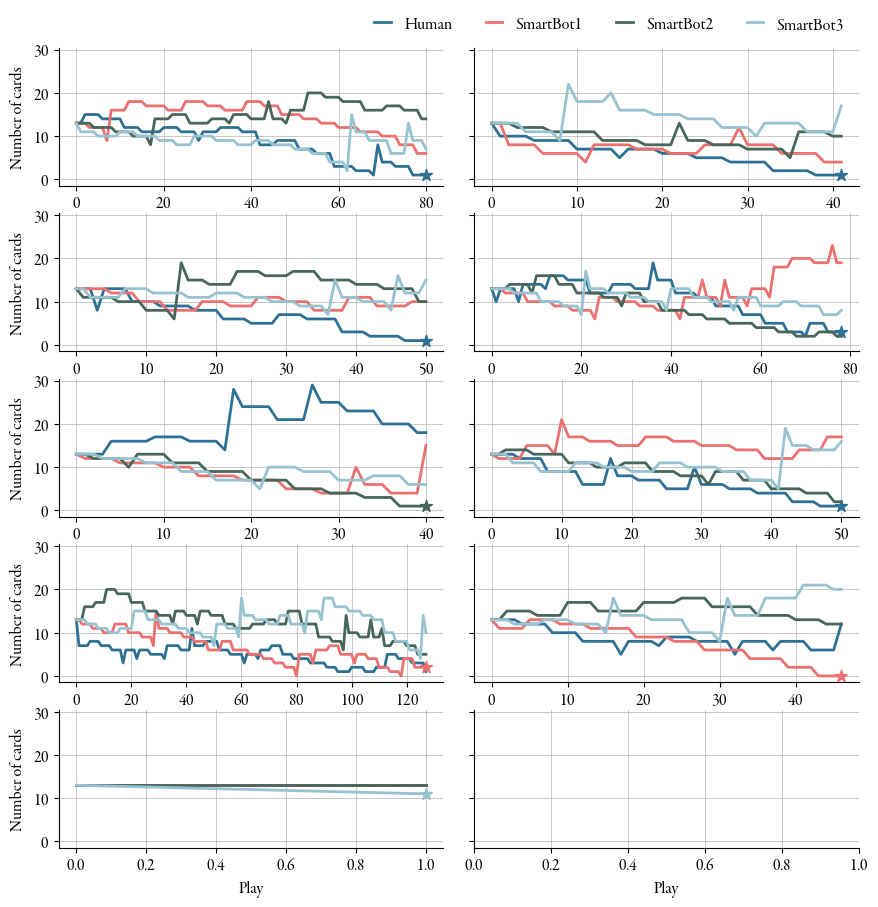

In [314]:
fig, axs = plt.subplots(figsize=(8, 8), ncols=2, nrows=5, sharex=False, sharey=True, gridspec_kw={'wspace': 0.08})
game_data = history_to_df(game_history_human_vs_SB)
player_cols = [col for col in game_data.columns if 'Player ' in col]
player_names = {'Player 0': 'Human', 'Player 1': 'SmartBot1', 'Player 2': 'SmartBot2', 'Player 3': 'SmartBot3'}
for idx in game_data['round'].unique():
    _d = game_data[(game_data['round']==idx) & ~(game_data['state'].isin(['win', 'discard']))][player_cols].map(len).rename(player_names, axis=1).reset_index(drop=True)
    for i, player in enumerate(_d.columns):
        _l = axs.flatten()[idx-1].plot(_d[player], label=player, lw=2)
        if game_data[(game_data['round']==idx)].iloc[-1]['Player'] == i:
            axs.flatten()[idx-1].scatter(len(_d)-1, _d.iloc[-1, i], c=_l[0].get_color(), marker='*', zorder=2, s=80)
for i in range(axs.shape[0]):
    axs[i, 0].set(ylabel='Number of cards')
for i in range(axs.shape[1]):
    axs[-1, i].set(xlabel="Play")
axs[0, 1].legend(ncols=4, bbox_to_anchor=(1, 1), loc='lower right')

In [ ]:
winners = []
lie_rate = []
call_rate = []

In [51]:
# Play 100 games with 10 rounds each
n_games = 100
n_rounds = 10
for _ in tqdm.trange(n_games):
    game = setup_game(num_players=6)
    game_winners = []
    game_p_lie = []
    game_p_call = []
    for i in range(n_rounds):
        await game.play_round(sleep_pause=0)
        game_winners.append(game.winner)

        # Estimated call rate
        game_p_call.append(game.players[0].other_player_repr[0].get('p_call_est', np.nan))

        # Estimate lie rate
        _l, _p = 0, 0
        for action in game.history[::-1]:
            if action.type == 'new_round':
                break
            if action.type == 'play' and action.player_id == 0:
                _p += 1
            if action.type == 'play' and action.player_id == 0 and not all([c.rank == action.data['declared_rank'] for c in action.data['cards_played']]):
                _l += 1
        game_p_lie.append(_l/_p)
        #game_p_lie.append(game.players[0].other_player_repr[0]['p_lie_est'])
        game.new_round()
    winners.append(game_winners)
    lie_rate.append(game_p_lie)
    call_rate.append(game_p_call)

100%|██████████| 100/100 [1:38:26<00:00, 59.07s/it]


Text(0.5, 1.15, 'Is SmartBot better than a random bot?')

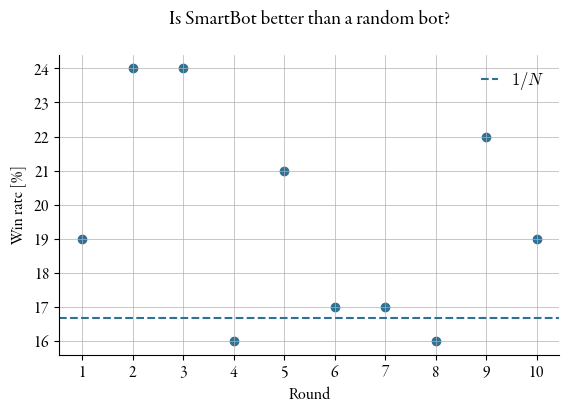

In [52]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(np.arange(np.stack(winners).shape[1])+1, 100*(np.stack(winners)==0).sum(axis=0) / np.stack(winners).shape[0])
ax.set(ylabel='Win rate [%]', xlabel='Round')
ax.axhline(100*1/6, ls='dashed', label=r'$1/N$')
ax.legend()
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.suptitle("Is SmartBot better than a random bot?", y=1.15)

Text(0.5, 1.21, "How does SmartBot's strategy evolve over time?")

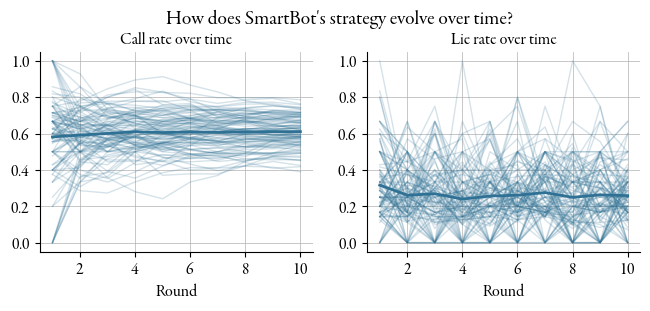

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 2))
axs[0].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(call_rate).T, c=colors['c_darkblue'], alpha=0.2, lw=1)
axs[0].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(call_rate).T.mean(axis=1), c=colors['c_darkblue'], lw=2)
axs[0].set(xlabel='Round', title="Call rate over time")
axs[1].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(lie_rate).T, c=colors['c_darkblue'], alpha=0.2, lw=1)
axs[1].plot(np.arange(np.stack(winners).shape[1])+1, np.stack(lie_rate).T.mean(axis=1), c=colors['c_darkblue'], lw=2)
axs[1].set(xlabel='Round', title="Lie rate over time")
fig.suptitle("How does SmartBot's strategy evolve over time?", y=1.21)

In [ ]:
# data = np.array(winner_properties)
# x, y = data[:,0], data[:,1]
# # Define bin edges
# xbins = np.linspace(x.min(), x.max(), 10)   # 50 bins
# ybins = np.linspace(y.min(), y.max(), 10)
#
# # 2D counts
# counts, _, _, _ = binned_statistic_2d(
#     x, y, None, statistic='count', bins=[xbins, ybins]
# )
#
# plt.imshow(
#     counts.T,
#     origin='lower',
#     extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
#     aspect='auto'
# )
# plt.colorbar(label='count')
# plt.xlabel('p_call')
# plt.ylabel('p_lie')
# plt.show()

## Mixed LLM-bot game

In [68]:
N_players = 4

system_prompt_template = "You are playing Cheat with {N_players} other players. You are Player {player_id}. Goal: get rid of all cards. On your turn: play 1-3 cards face down and declare a rank (Aces cannot be declared). You can bluff - cards don't need to match declaration. Options: 'Call' (challenge previous play), 'Play [cards]' (follow current rank), or 'Play [cards]; Declare rank' (start new rank when pile empty). Four-of-a-kind auto-discard. Win by emptying hand. FORMAT REQUIREMENTS: - Respond ONLY with: 'Call', 'Play [card1, card2]', or 'Play [cards]; Declare rank' - Use J/Q/K/A for face cards - Examples: 'Play [4♣, 4♦]; Declare 4', 'Play [A♠, K♥]', 'Play [2♥, J♣]; Declare J' - NO extra text: backend parsing depends on exact format."

In [71]:
# Fill up with bots
game_players=[]
for i in range(N_players):
    if i in [0, 1]:
        game_players.append(LLM_Player(
            id=i,
            name=f'DeepSeek_{i}',
            avatar='🤖',
            system_prompt = system_prompt_template.format(N_players=N_players-1,  player_id=i),
            kind='deepseek',
            model_kwargs=dict(model='deepseek-chat', stream=False)
        ))
    elif i == 2:
        game_players.append(SmartBot(
            id=i,
            name=f'SmartBot_{i}',
            avatar='🌼',
            #p_call=np.random.rand(),
            #p_lie=np.random.rand(),
            verbosity=0
        ))
    else:
        game_players.append(RandomBot(
            id=i,
            name=f'RandomBot_{i}',
            avatar='🌼',
            p_call=0.5,
            p_lie=0.5,
            verbosity=0
        ))
    # if i == 0:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'ChatGPT',
    #         avatar='🌼',
    #         init_prompt = dict(
    #         kind='open_ai',
    #         model='gpt-5-nano'
    #     ))

    # elif i == 2:
    #     game_players.append(LLM_Player(
    #         id=i,
    #         name=f'Google Gemini',
    #         avatar='🌼',
    #         init_prompt = input_prompt,
    #         kind='gemini',
    #         model='gemini-3-pro-preview'
    #     ))
# Set up a new game. Each game maintains its own message queue
game = CheatGame(
    players=game_players,
    experimental_mode=False,
    game_mode='single',
    message_queue = asyncio.Queue(), # Set up a new queue
    out_dir="game_data"
)

In [72]:
n_rounds = 10
for i in tqdm.trange(n_rounds):
    await game.play_round(sleep_pause=0)
    if i != n_rounds-1:
        game.new_round()

  0%|          | 0/10 [00:00<?, ?it/s]21:28:15  GAME       INFO      [77e6d915]  Current player: SmartBot_2 (id: 2, type: bot)
21:28:15  PLAYER     INFO      [77e6d915]  SmartBot_2 plays K♦ and declares K.
21:28:15  GAME       INFO      [77e6d915]  Current player: RandomBot_3 (id: 3, type: bot)
21:28:15  PLAYER     INFO      [77e6d915]  RandomBot_3 plays J♠, A♦, 10♥ and declares K.
21:28:15  GAME       INFO      [77e6d915]  Current player: DeepSeek_0 (id: 0, type: LLM)
21:28:18  PLAYER     INFO      [77e6d915]  LLM response: Play [K♠]
21:28:18  PLAYER     INFO      [77e6d915]  DeepSeek_0 plays K♠ and declares K.
21:28:18  GAME       INFO      [77e6d915]  Current player: DeepSeek_1 (id: 1, type: LLM)
21:28:20  PLAYER     INFO      [77e6d915]  LLM response: Play [J♥, J♦, J♣]; Declare J
21:28:22  PLAYER     INFO      [77e6d915]  LLM response: Play [J♥, J♦, J♣]
21:28:22  PLAYER     INFO      [77e6d915]  DeepSeek_1 plays J♥, J♦, J♣ and declares K.
21:28:22  GAME       INFO      [77e6d915]  

In [73]:
# Reconstruct a DataFrame for each round
with open(f"{game.out_path}/game_history.jsonl", "r") as f:
    game_history = [json.loads(line) for line in f if line.strip()]

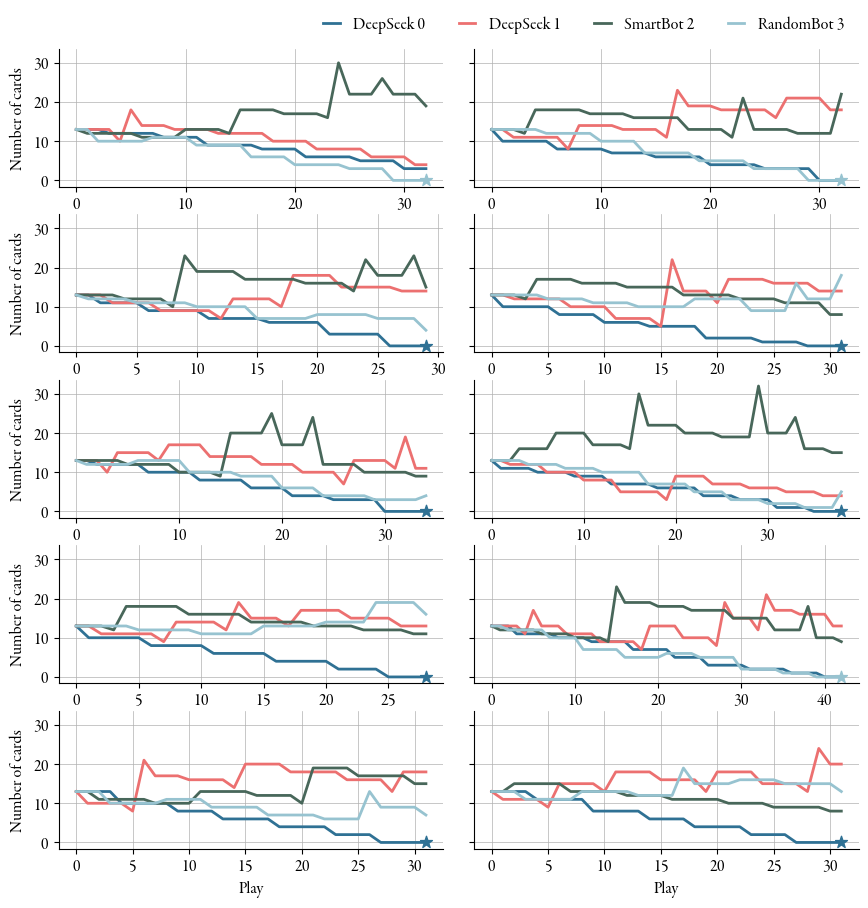

In [181]:
fig, axs = plt.subplots(figsize=(8, 8), ncols=2, nrows=5, sharex=False, sharey=True, gridspec_kw={'wspace': 0.08})
player_cols = [col for col in game_data.columns if 'Player ' in col]
player_names = dict((col, game.players[idx].name.replace('_', ' ')) for idx, col in enumerate(player_cols))
for idx in game_data['round'].unique():
    _d = game_data[(game_data['round']==idx) & ~(game_data['state'].isin(['win', 'discard']))][player_cols].map(len).rename(player_names, axis=1).reset_index(drop=True)
    for i, player in enumerate(_d.columns):
        _l = axs.flatten()[idx-1].plot(_d[player], label=player, lw=2)
        if game_data[(game_data['round']==idx)].iloc[-1]['Player'] == i:
            axs.flatten()[idx-1].scatter(len(_d)-1, _d.iloc[-1, i], c=_l[0].get_color(), marker='*', zorder=2, s=80)
for i in range(axs.shape[0]):
    axs[i, 0].set(ylabel='Number of cards')
for i in range(axs.shape[1]):
    axs[-1, i].set(xlabel="Play")
axs[0, 1].legend(ncols=4, bbox_to_anchor=(1, 1), loc='lower right')